# 00_Loading Pipeline

Build a leakage-safe train/test split and persist reproducible interim data artifacts.

## Notebook Layout
1. Configure shared styling and project paths.
2. Run loading pipeline and validate class distribution.
3. Save chart/table outputs for downstream reporting.

## Expert To-Do
- Add schema drift checks between raw source snapshots.
- Add deterministic data validation rules (row count, duplicate IDs, target domain).
- Version the interim split metadata (seed, split date, stratification metrics).


In [1]:
from pathlib import Path
import sys
import importlib

PROJECT_ROOT = Path.cwd().resolve().parent
SRC_DIR = PROJECT_ROOT / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

import notebook_checks as notebook_checks_mod
import styling.styling as styling_mod

importlib.reload(notebook_checks_mod)
importlib.reload(styling_mod)

from config import get_config
from loading_pipeline import run_loading_pipeline
from styling.plots import plot_target_distribution

run_basic_data_quality_gates = notebook_checks_mod.run_basic_data_quality_gates
build_reproducibility_footer = notebook_checks_mod.build_reproducibility_footer

apply_notebook_style = styling_mod.apply_notebook_style
build_eda_output_paths = styling_mod.build_eda_output_paths
build_artifact_path = styling_mod.build_artifact_path
save_table_snapshot = styling_mod.save_table_snapshot


In [2]:
cfg = get_config(PROJECT_ROOT)
apply_notebook_style()
figure_output_path, table_output_path = build_eda_output_paths(PROJECT_ROOT)

NOTEBOOK_ID = '00'
def fig_path(section_id: str, slug: str):
    return build_artifact_path(figure_output_path, NOTEBOOK_ID, section_id, slug, 'png')

def table_path(section_id: str, slug: str, extension: str = 'png'):
    return build_artifact_path(table_output_path, NOTEBOOK_ID, section_id, slug, extension)

artifacts = run_loading_pipeline(cfg, save=True)

quality_report = run_basic_data_quality_gates(
    train_df=artifacts.train_df,
    test_df=artifacts.test_df,
    target_col=cfg.target_col,
    required_cols=[cfg.target_col, 'encounter_id', 'patient_nbr'],
    leakage_id_cols=['encounter_id'],
)
display(quality_report)

save_table_snapshot(
    quality_report,
    table_path('01', 'quality_gates_report'),
    title='Loading Pipeline - Data Quality Gates (Class and Leakage Checks)',
    index=False,
)
quality_report.to_csv(table_path('01', 'quality_gates_report', 'csv'), index=False)

class_distribution = artifacts.class_distribution.reset_index().rename(columns={"index": "readmitted_class"})

save_table_snapshot(
    class_distribution,
    table_path('02', 'class_distribution_summary'),
    title='Loading Pipeline - Class Distribution Summary',
    index=False,
)
class_distribution.to_csv(table_path('02', 'class_distribution_summary', 'csv'), index=False)

class_distribution


,readmitted,count,percentage,dataset
0,NO,43891,53.91,train
1,>30,28436,34.93,train
2,<30,9085,11.16,train
3,NO,10973,53.91,test
4,>30,7109,34.93,test
5,<30,2272,11.16,test


,readmitted,count,percentage
0,NO,54864,53.91
1,>30,35545,34.93
2,<30,11357,11.16


,timestamp_utc,python_version,platform,random_seed,numpy,pandas,sklearn,matplotlib,seaborn
0,2026-02-18T11:23:56+00:00,3.11.0,macOS-26.2-arm64-arm-64bit,42,1.26.4,2.2.0,1.7.2,3.10.6,0.13.2


Train saved to: /Users/casimircasparuhlig/Desktop/classification-project-casimiruhlig/data/interim/train.csv
Test saved to: /Users/casimircasparuhlig/Desktop/classification-project-casimiruhlig/data/interim/test.csv
EDA figures saved to: /Users/casimircasparuhlig/Desktop/classification-project-casimiruhlig/output/eda/figures
EDA tables saved to: /Users/casimircasparuhlig/Desktop/classification-project-casimiruhlig/src/eda/tables


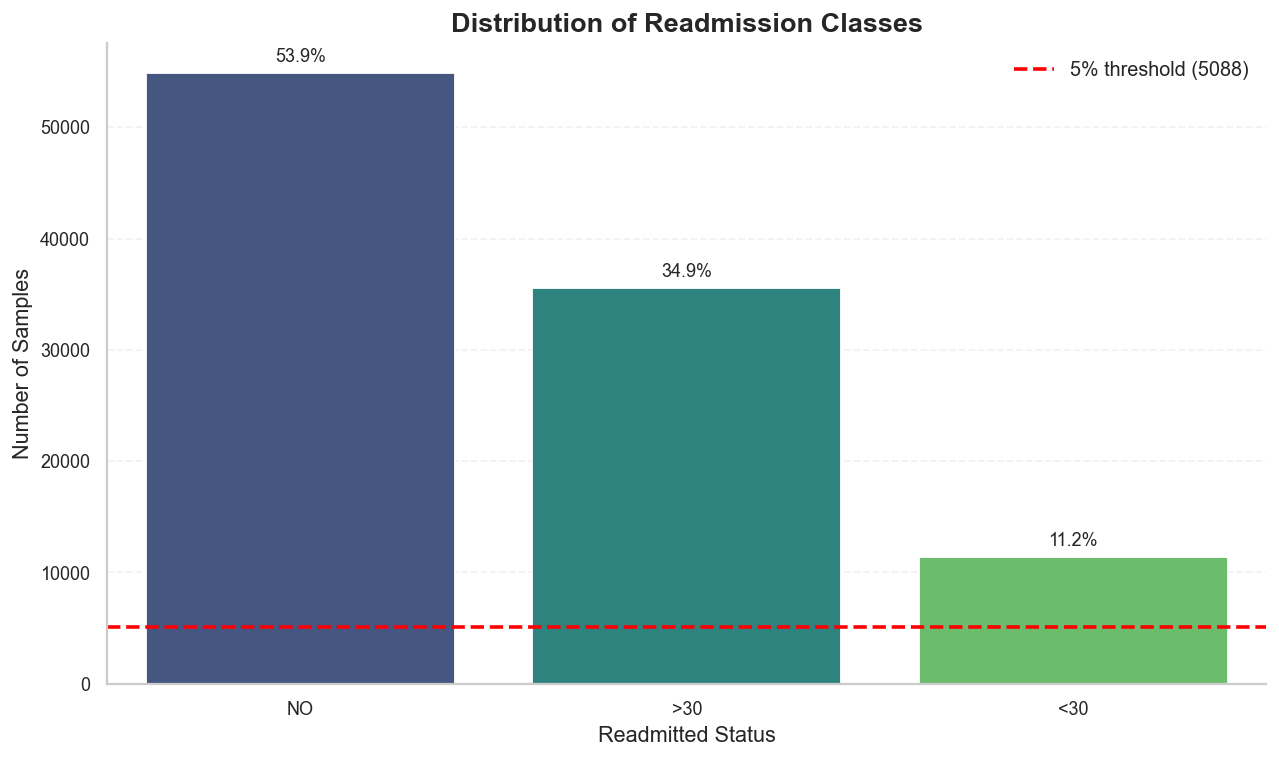

In [3]:
plot_target_distribution(
    artifacts.raw_df,
    target_col=cfg.target_col,
    threshold_pct=0.05,
    save_path=fig_path('03', 'target_distribution'),
)

repro_footer = build_reproducibility_footer(cfg.random_state)
display(repro_footer)
save_table_snapshot(
    repro_footer,
    table_path('99', 'reproducibility_footer'),
    title='Loading Pipeline - Reproducibility Footer',
    index=False,
)
repro_footer.to_csv(table_path('99', 'reproducibility_footer', 'csv'), index=False)

print(f"Train saved to: {cfg.interim_train_path}")
print(f"Test saved to: {cfg.interim_test_path}")
print(f"EDA figures saved to: {figure_output_path}")
print(f"EDA tables saved to: {table_output_path}")
